In [1]:
import findspark
findspark.init()

In [2]:
############################TASK 1####################################################

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
spark = SparkSession.builder.getOrCreate()

#creating schema
ratingSchema = StructType([
    StructField("userID", IntegerType(), nullable=False),
    StructField("FilmID", IntegerType(), nullable=False),
    StructField("rating_value", FloatType(), nullable=False)
])

trustSchema = StructType([
    StructField("Trustor", IntegerType(), nullable=False),
    StructField("Trustee", IntegerType(), nullable=False),
    StructField("Trust_Value", FloatType(), nullable=False)
])

#loading data set and printing out
ratingsDF = spark.read.csv("ratings.txt", schema=ratingSchema, header=False, sep=' ')
ratingsDF.show()
ratingCount = ratingsDF.count()

trustDF = spark.read.csv("trust.txt", schema=trustSchema, header=False, sep=' ')
trustDF.show()
trustCount = trustDF.count()

print(ratingCount, trustCount)

#calculating counts after removing records with null values
ratingsDF = ratingsDF.dropna()
ratingAfterNullRemoved = ratingsDF.count()
trustDF = trustDF.dropna()
trustAfterNullRemoved = trustDF.count()
print("Original ratings count: ", ratingCount)
print("New ratings count after removing nulls: ", ratingAfterNullRemoved)
print("Original trust count: ", trustCount)
print("New trust count after removing nulls: ", trustAfterNullRemoved)

#calculating counts after removing records that are duplicates
ratingsDF = ratingsDF.dropDuplicates()
ratingAfterDuplicate = ratingsDF.count()
ratingDiff = ratingAfterNullRemoved - ratingAfterDuplicate
trustDF = trustDF.dropDuplicates()
trustAfterDuplicate = trustDF.count()
trustDiff = trustAfterNullRemoved - trustAfterDuplicate
print("Ratings count before removing duplicates: ", ratingAfterNullRemoved)
print(f"Ratings count after removing duplicates: {ratingAfterDuplicate} ({ratingDiff})")
print("Trust count before removing duplicates: ", trustAfterNullRemoved)
print(f"Trust count after removing duplicates: {trustAfterDuplicate} ({trustDiff})")


/usr/local/lib/python3.12/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/06 13:31:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+------+------------+
|userID|FilmID|rating_value|
+------+------+------------+
|     1|     1|         2.0|
|     1|     2|         4.0|
|     1|     3|         3.5|
|     1|     4|         3.0|
|     1|     5|         4.0|
|     1|     6|         3.5|
|     1|     7|         3.5|
|     1|     8|         3.0|
|     1|     9|         2.5|
|     1|    10|         4.0|
|     1|    11|         4.0|
|     1|    12|         4.0|
|     2|    13|         2.0|
|     3|    14|         0.5|
|     3|    15|         1.0|
|     3|    16|         4.0|
|     3|    17|         3.0|
|     3|    18|         4.0|
|     3|    19|         4.0|
|     3|    20|         2.5|
+------+------+------------+
only showing top 20 rows

+-------+-------+-----------+
|Trustor|Trustee|Trust_Value|
+-------+-------+-----------+
|      2|    966|        1.0|
|      2|    104|        1.0|
|      5|   1509|        1.0|
|      6|   1192|        1.0|
|      7|   1510|        1.0|
|     12|    234|        1.0|
|     15

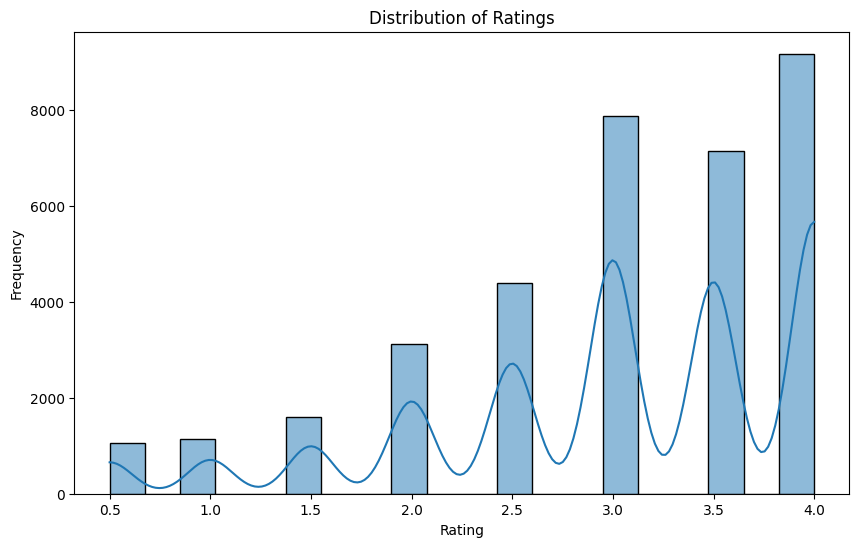

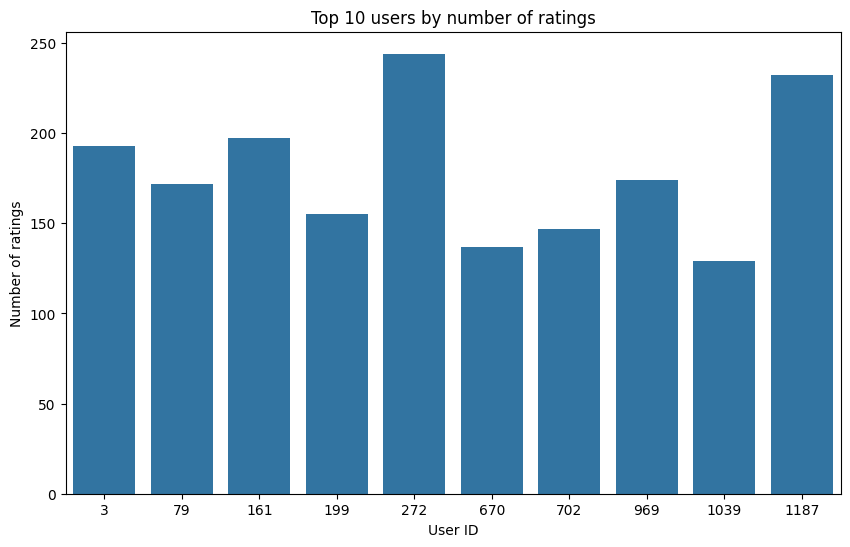

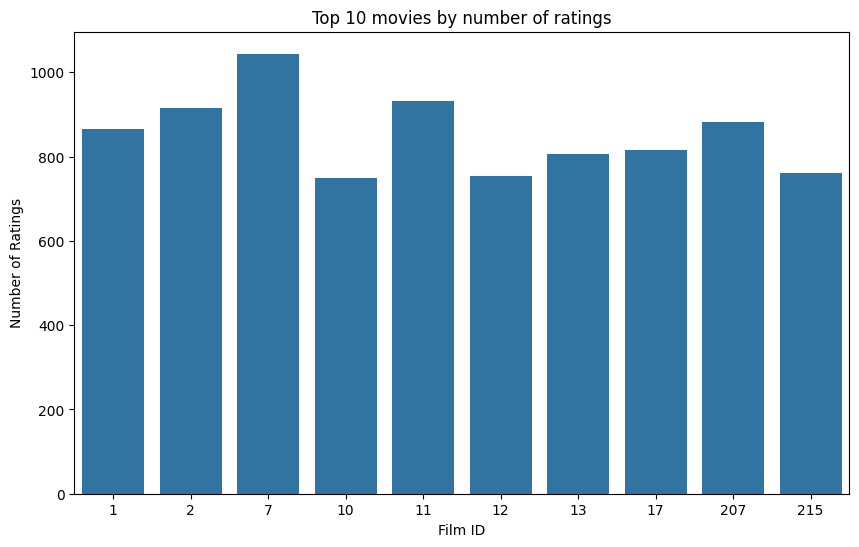


Trust Summary:
           Trustor      Trustee  Trust_Value
count  1853.000000  1853.000000       1853.0
mean    775.437669   782.192121          1.0
std     447.736536   471.614626          0.0
min       2.000000     2.000000          1.0
25%     410.000000   395.000000          1.0
50%     752.000000   716.000000          1.0
75%    1160.000000  1187.000000          1.0
max    1641.000000  1642.000000          1.0


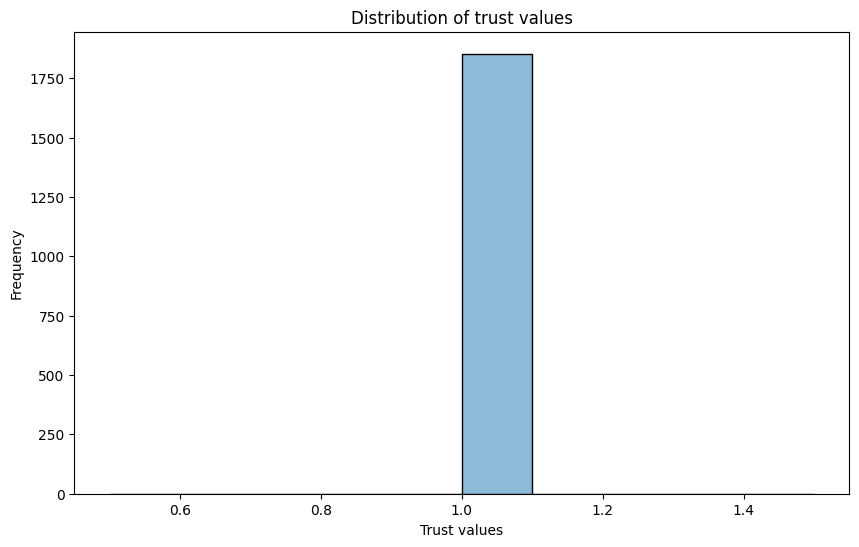

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import setuptools

#convert spark dataframes into pandas dataframes for seaborn
ratingspDF = ratingsDF.toPandas()
trustpDF = trustDF.toPandas()

#distribution of ratings
plt.figure(figsize=(10,6))
sns.histplot(ratingspDF['rating_value'], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

#top 10 users by number of ratings
topUsers = ratingspDF['userID'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=topUsers.index, y=topUsers.values)
plt.title("Top 10 users by number of ratings")
plt.xlabel("User ID")
plt.ylabel("Number of ratings")
plt.show()

#top 10 films by number of ratings
topMovies = ratingspDF['FilmID'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=topMovies.index, y=topMovies.values)
plt.title("Top 10 movies by number of ratings")
plt.xlabel("Film ID")
plt.ylabel("Number of Ratings")
plt.show()

#summary statistics for trust data
trustSummary = trustpDF.describe()
print("\nTrust Summary:")
print(trustSummary)

#distribution of trust values
plt.figure(figsize=(10,6))
sns.histplot(trustpDF['Trust_Value'], bins=10, kde=True)
plt.title("Distribution of trust values")
plt.xlabel("Trust values")
plt.ylabel("Frequency")
plt.show()

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

#split data into training and test sets
(trainingDF, testDF) = ratingsDF.randomSplit([0.8, 0.2], seed=42)

#initialise als model
als = ALS(
    maxIter=10,
    regParam=0.1,
    rank=10,
    userCol="userID",
    itemCol="FilmID",
    ratingCol="rating_value",
    coldStartStrategy="drop"
)

#training als model
alsModel = als.fit(trainingDF)

#make predictions on test data
predictions = alsModel.transform(testDF)
predictions.show(5)

#evaluation of model
evaluator = RegressionEvaluator(
    metricName = "rmse",
    labelCol = "rating_value",
    predictionCol = "prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root mean squared error = {rmse}")

maeEvaluator = RegressionEvaluator(
    metricName = "mae",
    labelCol = "rating_value",
    predictionCol = "prediction"
)
mae = maeEvaluator.evaluate(predictions)
print(f"mean absolute error = {mae}")

#recommend top 5 films for each user
userRecommendations = alsModel.recommendForAllUsers(5)
userRecommendations.show(5)

#recommend 5 users for each film
filmRecommendations = alsModel.recommendForAllItems(5)
filmRecommendations.show(5)

24/12/06 13:37:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/06 13:37:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+------+------+------------+----------+
|userID|FilmID|rating_value|prediction|
+------+------+------------+----------+
|     1|     3|         3.5| 2.9791136|
|     1|     7|         3.5| 3.1295288|
|     1|     9|         2.5|  3.480434|
|     3|     6|         0.5|  1.697159|
|     3|    22|         2.0| 1.8464725|
+------+------+------------+----------+
only showing top 5 rows

Root mean squared error = 0.8672603356571297
mean absolute error = 0.6696552465020411


+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|     1|[{68, 5.9946246},...|
|     3|[{1508, 4.1761355...|
|     5|[{208, 2.9219952}...|
|     6|[{1508, 5.5924892...|
|     9|[{162, 4.5110393}...|
+------+--------------------+
only showing top 5 rows



+------+--------------------+
|FilmID|     recommendations|
+------+--------------------+
|     1|[{598, 3.9181993}...|
|     3|[{896, 3.821713},...|
|     5|[{896, 4.0463123}...|
|     6|[{710, 3.788246},...|
|    12|[{1458, 3.893962}...|
+------+--------------------+
only showing top 5 rows




Number of Flights from Each Airport
{'JFK': 25, 'ORD': 33, 'DEN': 45, 'KUL': 33, 'MAD': 13, 'LHR': 25, 'CGK': 27, 'MUC': 14, 'AMS': 15, 'DFW': 11, 'MIA': 11, 'CDG': 21, 'CAN': 37, 'IAH': 37, 'LAS': 17, 'CLT': 21, 'ATL': 36, 'PVG': 20, 'FCO': 15, 'BKK': 17, 'PEK': 13, 'HND': 13}

List of Unused Airports
['PHX', 'IST']

List of Flights with Details
{'Number of Passengers': 25, 'Flight ID': 'XXQ4064B', 'Departure Airport': 'JFK', 'Arrival Airport': 'FRA', 'Formatted Departure Time': '17:05', 'Formatted Arrival Time': '06:27'}
{'Number of Passengers': 18, 'Flight ID': 'SOH3431A', 'Departure Airport': 'ORD', 'Arrival Airport': 'MIA', 'Formatted Departure Time': '17:00', 'Formatted Arrival Time': '21:10'}
{'Number of Passengers': 18, 'Flight ID': 'PME8178S', 'Departure Airport': 'DEN', 'Arrival Airport': 'PEK', 'Formatted Departure Time': '17:13', 'Formatted Arrival Time': '15:15'}
{'Number of Passengers': 16, 'Flight ID': 'MBA8071P', 'Departure Airport': 'KUL', 'Arrival Airport': 'PEK', 'F

/tmp/ipykernel_656/959297975.py:31: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(int(epoch)).strftime('%H:%M')



Passenger with the Highest Air Miles
Passenger ID: BWI0520BG6, Total Miles: 124942.56


<Figure size 1200x600 with 0 Axes>

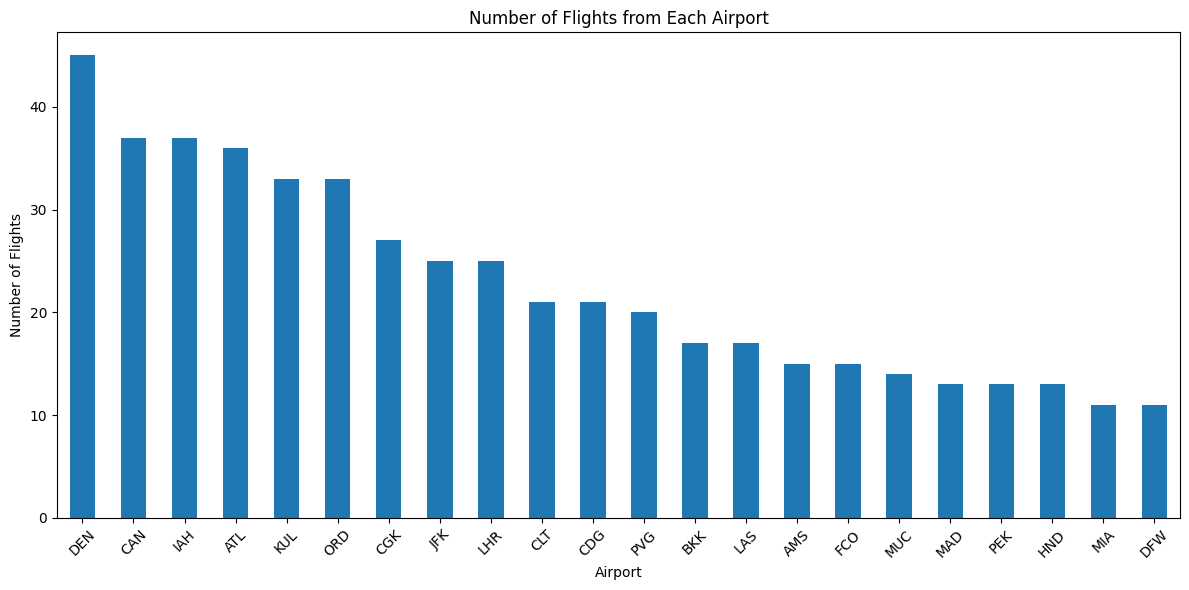

<Figure size 1200x600 with 0 Axes>

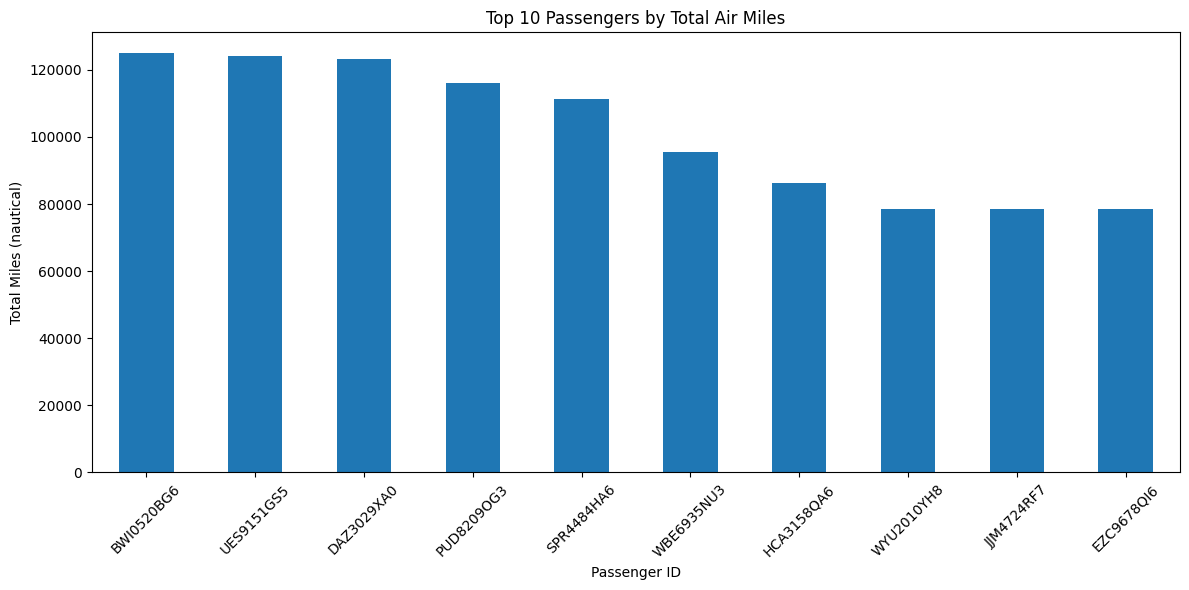

In [1]:
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
from collections import defaultdict
import matplotlib.pyplot as plt

# Load datasets
passenger_data = pd.read_csv('AComp_Passenger_data_no_error.csv')
airport_data = pd.read_csv('Top30_airports_LatLong.csv')

# Rename columns for clarity
passenger_data.columns = [
    "Passenger ID",
    "Flight ID",
    "From Airport",
    "Destination Airport",
    "Departure Time",
    "Total Flight Time"
]

airport_data.columns = [
    "Airport Name",
    "IATA/FAA Code",
    "Latitude",
    "Longitude"
]

# Helper function to convert epoch time to HH:MM format
def convert_epoch_to_hhmm(epoch):
    try:
        return datetime.utcfromtimestamp(int(epoch)).strftime('%H:%M')
    except (ValueError, TypeError):
        return None


#Number of flights from each airport and unused airports


# Mapper: Count flights from each airport
def map_flights_from_airports(data):
    result = defaultdict(int)
    for _, row in data.iterrows():
        result[row['From Airport']] += 1
    return result

# Reducer: Aggregate counts
def reduce_flights_count(mapped_results):
    reduced_result = defaultdict(int)
    for result in mapped_results:
        for airport, count in result.items():
            reduced_result[airport] += count
    return reduced_result

# Map
mapped_flights = map_flights_from_airports(passenger_data)

# Reduce
flights_from_airports = reduce_flights_count([mapped_flights])

# Determine unused airports
used_airports = set(passenger_data['From Airport']).union(set(passenger_data['Destination Airport']))
all_airports = set(airport_data['IATA/FAA Code'])
unused_airports = all_airports - used_airports

print("\nNumber of Flights from Each Airport")
print(dict(flights_from_airports))

print("\nList of Unused Airports")
print(list(unused_airports))


#List of flights with details


# Mapper: Collect flight details
def map_flight_details(data):
    result = []
    for _, row in data.iterrows():
        departure_time = convert_epoch_to_hhmm(row['Departure Time'])
        arrival_time = convert_epoch_to_hhmm(row['Departure Time'] + row['Total Flight Time'] * 60)
        result.append({
            "Flight ID": row['Flight ID'],
            "Number of Passengers": 1,
            "Departure Airport": row['From Airport'],
            "Arrival Airport": row['Destination Airport'],
            "Formatted Departure Time": departure_time,
            "Formatted Arrival Time": arrival_time
        })
    return result

# Reducer: Combine passenger counts for each flight
def reduce_flight_details(mapped_results):
    reduced_result = defaultdict(lambda: {"Number of Passengers": 0})
    for flight in mapped_results:
        flight_id = flight["Flight ID"]
        reduced_result[flight_id]["Flight ID"] = flight_id
        reduced_result[flight_id]["Number of Passengers"] += 1
        reduced_result[flight_id]["Departure Airport"] = flight["Departure Airport"]
        reduced_result[flight_id]["Arrival Airport"] = flight["Arrival Airport"]
        reduced_result[flight_id]["Formatted Departure Time"] = flight["Formatted Departure Time"]
        reduced_result[flight_id]["Formatted Arrival Time"] = flight["Formatted Arrival Time"]
    return list(reduced_result.values())

# Map
mapped_flight_details = map_flight_details(passenger_data)

# Reduce
flights = reduce_flight_details(mapped_flight_details)

print("\nList of Flights with Details")
for flight in flights[:5]:  # Print first 5 for brevity
    print(flight)


#Calculate air miles and top passenger


# Mapper: Calculate distances for each passenger
def map_passenger_distances(data):
    result = defaultdict(float)
    for _, row in data.iterrows():
        try:
            from_coords = airport_data.loc[airport_data['IATA/FAA Code'] == row['From Airport'], ['Latitude', 'Longitude']].values[0]
            to_coords = airport_data.loc[airport_data['IATA/FAA Code'] == row['Destination Airport'], ['Latitude', 'Longitude']].values[0]
            distance = geodesic(from_coords, to_coords).nautical
        except IndexError:
            distance = 0  # Skip invalid airports
        result[row['Passenger ID']] += distance
    return result

# Reducer: Sum distances for each passenger
def reduce_passenger_distances(mapped_results):
    reduced_result = defaultdict(float)
    for result in mapped_results:
        for passenger, distance in result.items():
            reduced_result[passenger] += distance
    return reduced_result

# Map
mapped_passenger_distances = map_passenger_distances(passenger_data)

# Reduce
passenger_miles = reduce_passenger_distances([mapped_passenger_distances])

# Find the passenger with the highest air miles
top_passenger = max(passenger_miles.items(), key=lambda x: x[1])

print("\nPassenger with the Highest Air Miles")
print(f"Passenger ID: {top_passenger[0]}, Total Miles: {top_passenger[1]:.2f}")


# Visualisation


#Flights per Airport
flights_from_airports_df = pd.DataFrame(list(flights_from_airports.items()), columns=['Airport', 'Num_Flights'])

plt.figure(figsize=(12, 6))
flights_from_airports_df.sort_values(by='Num_Flights', ascending=False).plot(
    x='Airport', 
    y='Num_Flights', 
    kind='bar', 
    legend=False, 
    title='Number of Flights from Each Airport',
    xlabel='Airport',
    ylabel='Number of Flights',
    figsize=(12, 6)
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Top Passengers by Air Miles
passenger_miles_df = pd.DataFrame(list(passenger_miles.items()), columns=['Passenger ID', 'Total Miles'])
top_10_passengers = passenger_miles_df.nlargest(10, 'Total Miles')

plt.figure(figsize=(12, 6))
top_10_passengers.plot(
    x='Passenger ID', 
    y='Total Miles', 
    kind='bar', 
    legend=False, 
    title='Top 10 Passengers by Total Air Miles',
    xlabel='Passenger ID',
    ylabel='Total Miles (nautical)',
    figsize=(12, 6)
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
